## Columbia University E4620 Final Project
Author @Alex Wei, Last modified: Dec. 16, 2025

In [22]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix, root_mean_squared_error as rms, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams["font.family"] = "Arial"
import matplotlib.pyplot as plt

DIR = Path('./datasets')
RATE_L, TARIFF = 26.67, 15.0        # converted to USD
IMP_THRESH, EXP_THRESH = 15.0, -5.0 # economic thresholds for IO decisions
CAPACITY = 1250                     # assume same as Hertel-NY

def mgs(A): # copied from my HW3Q5
    m, n = A.shape
    Q, R, V = np.zeros((m,n)), np.zeros((n,n)), A.copy().astype(float)
    for j in range(n):
        for i in range(j):
            R[i, j] = Q[:, i] @ V[:, j]
            V[:, j] -= R[i, j] * Q[:, i]
        R[j, j] = np.linalg.norm(V[:, j])
        Q[:, j] = V[:, j] / R[j, j] if R[j, j] > 1e-12 else V[:, j]
    return Q, R

def ridge_qr(X, y, lam):
    X_aug = np.vstack([X, np.sqrt(lam) * np.eye(X.shape[1])])
    y_aug = np.concatenate([y, np.zeros(X.shape[1])])
    Q, R = mgs(X_aug)
    return np.linalg.solve(R, Q.T @ y_aug)

def hard_impute(X, rank, tol=1e-4):    # REF [1]
    X_f = X.copy()  # filled
    msk = np.isnan(X)
    if not np.any(msk):
        return X_f
    row_mean = np.nanmean(X, axis=1)
    for i in range(X.shape[0]):
        X_f[i, msk[i, :]] = (row_mean[i] if not np.isnan(row_mean[i]) else np.nanmean(X))
    for _ in range(50): # adjustable max iter
        X_old = X_f.copy()
        U, s, Vt = np.linalg.svd(X_f, full_matrices=False)
        s[rank:] = 0
        X_f[msk] = (U @ np.diag(s) @ Vt)[msk]
        if np.linalg.norm(X_f - X_old, 'fro') < tol:
            break
    return X_f

### Data loading

In [23]:
data = pd.DataFrame(index=pd.date_range('2015-01-01', '2024-12-31 23:00:00', freq='h'))

for dtype, folder, names in [('RT LBMP', 'NYISO_RT_LBMP', ['N.Y.C.', 'WEST']),
                             ('DA LBMP', 'NYISO_DA_LBMP', ['N.Y.C.']),
                             ('Loads', 'NYISO_Load', ['N.Y.C.'])]:
    dfs = [pd.read_csv(f, parse_dates=[0]) for f in tqdm(sorted((DIR/folder).glob('*.csv')), desc=dtype, leave=False)]
    dfs = [df[df.iloc[:, 1].isin(names) if dtype != 'Loads' else df['Name'].isin(names)] for df in dfs]
    if not dfs: continue
    df = pd.concat(dfs, ignore_index=True)

    if dtype == 'Loads':
        data['Load'] = (df.pivot_table(index='Time Stamp', columns='Name', values='Load', aggfunc='mean')['N.Y.C.'].resample('h').mean())
    else:
        df_pivot = df.pivot_table(index=df.columns[0], columns=df.columns[1], values=df.columns[3], aggfunc='mean')
        prefix = 'DA_' if dtype == 'DA LBMP' else ''
        for col in df_pivot.columns:
            data[f'{prefix}LBMP_{col.replace("N.Y.C.", "NYC").replace(" ", "_")}'] = (df_pivot[col].resample('h').mean())

# weather data
df = pd.read_csv(DIR/'NOAA/KNYC.csv', parse_dates=['valid'])
df[['tmpc', 'dwpc', 'sped']] = df[['tmpc', 'dwpc', 'sped']].apply(pd.to_numeric, errors='coerce')
df_nyc = df.set_index('valid')[['tmpc', 'dwpc', 'sped']].resample('h').mean()
data[['Temp', 'NYC_Dewpoint', 'NYC_Windspeed']] = df_nyc[['tmpc', 'dwpc', 'sped']]

data = data.interpolate(method='time', limit=48).ffill(limit=72).bfill(limit=72)

### Feature engineering
ACADEMIC INTEGRITY CLAIM: lagged feature, HDD/CDD and some temporal features suggested by GenAI

In [24]:
n_days = len(data['Load']) // 24
load_matrix = hard_impute(data['Load'].values[:n_days * 24].reshape(n_days, 24).T, rank=3)
U, s, Vt = np.linalg.svd(load_matrix, full_matrices=False)
d_eig = U[:, :3]

data['Load_Completed'] = np.nan
data.iloc[:n_days * 24, data.columns.get_loc('Load_Completed')] = load_matrix.T.flatten()
data['Load_Completed'] = data['Load_Completed'].bfill().ffill()

# eigen day coeffs
for i, coef in enumerate((Vt[:3, :] * s[:3, None]).T.T):
    data[f'Eigen_{i + 1}'] = np.nan
    data.iloc[:n_days*24, data.columns.get_loc(f'Eigen_{i + 1}')] = np.repeat(coef, 24)
data[['Eigen_1', 'Eigen_2', 'Eigen_3']] = (data[['Eigen_1', 'Eigen_2', 'Eigen_3']].bfill().ffill())

data['Spread'] = data['LBMP_NYC'] - (RATE_L + TARIFF)   # target variable
data['DA_Spread'] = data['DA_LBMP_NYC'] - (RATE_L + TARIFF) # main predictor (known 1 day ahead)

# price features: use DA and lagged RT for balance
x = data['LBMP_NYC'].shift(1)
data['Price_Range'] = x.rolling(24, min_periods=12).max() - x.rolling(24, min_periods=12).min()
data['HDD'] = np.maximum(0, 18.3 - data['Temp'])    # heating degree days
data['CDD'] = np.maximum(0, data['Temp'] - 18.3)    # cooling degree days
data['Temp_Sq'] = data['Temp'] ** 2                 # nonlinear temp effect

for lag in [1, 24, 168]:    # lagged feats
    for col, prefix in [('LBMP_NYC', 'LBMP'), ('DA_LBMP_NYC', 'DA'), ('Load_Completed', 'Load')]:
        data[f'{prefix}_L{lag}'] = data[col].shift(lag)

for w in [6, 12, 24]:   # moving avgs
    for col, prefix in [('LBMP_NYC', 'LBMP'), ('DA_LBMP_NYC', 'DA'), ('Load_Completed', 'Load')]:
        data[f'{prefix}_MA{w}'] = data[col].shift(1).rolling(w, min_periods=w // 2).mean()

# dynamics & volatility
data['LBMP_Trend'] = data['LBMP_NYC'].shift(1) - data['LBMP_NYC'].shift(25)
data['DA_Trend'] = data['DA_LBMP_NYC'].shift(1) - data['DA_LBMP_NYC'].shift(25)
data['Load_Trend'] = data['Load_Completed'].shift(1) - data['Load_Completed'].shift(25)
data['Price_Std'] = data['LBMP_NYC'].shift(1).rolling(24, min_periods=12).std()

# temporal feats (cyclical patterns)
dt_idx = pd.DatetimeIndex(data.index)
data['Hour_sin'] = np.sin(2 * np.pi * dt_idx.hour / 24)
data['Hour_cos'] = np.cos(2 * np.pi * dt_idx.hour / 24)
data['Month_sin'] = np.sin(2 * np.pi * dt_idx.month / 12)
data['Month_cos'] = np.cos(2 * np.pi * dt_idx.month / 12)
data['IsPeak'] = ((dt_idx.hour >= 7) & (dt_idx.hour <= 21)).astype(int) # peak pricing hrs
data['IsWeekend'] = (dt_idx.dayofweek >= 5).astype(int)

# interaction features
data['Load_Temp'] = data['Load_L1'] * data['Temp']
data['DA_Peak'] = data['DA_Spread'] * data['IsPeak']  # day ahead spread during peak

data['Label'] = np.where(data['Spread'] < EXP_THRESH, 0, np.where(data['Spread'] > IMP_THRESH, 2, 1))

### Data splitting + preprocessing

In [25]:
data = data.dropna()
train = data[data.index < '2022-01-01']
val = data[(data.index >= '2022-01-01') & (data.index < '2023-01-01')]
test = data[data.index >= '2023-01-01']

print(f"SAMPLES: {len(train)} train | {len(val)} val | {len(test)} test (EXP {sum(test['Label'] == 0)}, HOLD {sum(test['Label'] == 1)}, "f"IMP {sum(test['Label'] == 2)})")
print(f"train period: {train.index[0].strftime('%Y %m %d')} to "f"{train.index[-1].strftime('%Y %m %d')}")
print(f"test period: {test.index[0].strftime('%Y %m %d')} to "f"{test.index[-1].strftime('%Y %m %d')}")

feat = [c for c in data.columns if any(x in c for x in
                                       ['LBMP_L', 'LBMP_MA', 'LBMP_Trend', 'DA_L', 'DA_MA', 'DA_Spread', 'DA_Trend',
                                        'DA_Peak', 'Load_L', 'Load_MA', 'Load_Trend', 'Load_Temp',
                                        'HDD', 'CDD', 'Temp_Sq', 'Hour_', 'Month_', 'IsPeak', 'IsWeekend',
                                        'Price_Range', 'Price_Std', 'Eigen_', 'NYC_Dewpoint', 'NYC_Windspeed'])]

X_train, y_train = train[feat].values, train['Spread'].values
X_val, y_val = val[feat].values, val['Spread'].values
X_test, y_test = test[feat].values, test['Spread'].values
y_test_c = test['Label'].values
print(f"features: {len(feat)}")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val, X_test = scaler.transform(X_val), scaler.transform(X_test)

SAMPLES: 56755 train | 8760 val | 17544 test (EXP 12505, HOLD 3483, IMP 1556)
train period: 2015 01 08 to 2021 12 31
test period: 2023 01 01 to 2024 12 31
features: 41


### Regression model training

In [26]:
lams = np.logspace(-2, 3, 25)
val_rms = [rms(y_val, X_val @ ridge_qr(X_train, y_train, l)) for l in tqdm(lams, desc="tuning", leave=False)]
opt_lam = lams[np.argmin(val_rms)]
w = ridge_qr(X_train, y_train, opt_lam)
y_pred = X_test @ w

print(f"RMSE {rms(y_test, y_pred):.2f}, R² {r2_score(y_test, y_pred):.3f}")

RMSE 26.84, R² 0.419


### Classification via threshold calibration [2]

In [27]:
y_val_pred = X_val @ w
y_train_pred = X_train @ w
bias = np.mean(y_train - y_train_pred)
y_val_corr = y_val_pred + bias
y_corr = y_pred + bias

opt_score, th_low, th_high = 0, EXP_THRESH, IMP_THRESH
for t_low in np.linspace(-6, -3, 25):       # export must be negative
    for t_high in np.linspace(15, 25, 25):
        if t_high <= t_low + 12: continue
        tmp = np.where(y_val_corr > t_high, 2, np.where(y_val_corr < t_low, 0, 1))
        cm = confusion_matrix(val['Label'].values, tmp, labels=[0, 1, 2])
        den = cm.sum(0) + cm.sum(1)
        f1 = np.mean(np.where(den > 0, 2 * np.diag(cm) / den, 0.0))
        # normalized profit
        volume = np.where(tmp == 2, CAPACITY * np.minimum(1, y_val_corr / 50), 0)
        # weighted score for balanced optimization
        score = 0.8 * f1 + 0.2 * np.sum(volume * np.maximum(0, y_val_corr)) / 1e8
        if score > opt_score:
            opt_score, th_low, th_high = score, t_low, t_high

print(f"bias correction: ${bias:.2f}/MWh")
print(f"thresh: EXP < {th_low}, HOLD ∈ [{th_low}, {th_high}], IMP > {th_high}")

# apply to testset with bias correction
y_pred_c = np.ones(len(y_corr))
y_pred_c[y_corr > th_high], y_pred_c[y_corr < th_low] = 2, 0

# volume-adjusted profit calculation
volume = np.where(y_pred_c == 2, CAPACITY * np.minimum(1, y_corr / 50), 0)
profit = np.cumsum(volume * np.maximum(0, y_corr))

cm = confusion_matrix(y_test_c, y_pred_c)
cls = ['Export', 'Hold', 'Import']
print(f"\ntest acc: {np.mean(y_pred_c == y_test_c):.3f}")
for k, n in enumerate(cls):
    tp = cm[k, k]
    p = tp / cm[:, k].sum() if cm[:, k].sum() > 0 else 0
    r = tp / cm[k, :].sum() if cm[k, :].sum() > 0 else 0
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0
    print(f"{n:8s} prec {p:.3f}, rec {r:.3f}, F1 {f:.3f}")

print(f"total profit: ${profit[-1] / 1e6:.2f}M over {len(test)} hrs")
print(f"avg profit/hr: ${profit[-1] / sum(y_pred_c == 2):.0f}")
print(f"total energy imported: {volume.sum() / 1e6:.3f} TWh")

bias correction: $-8.51/MWh
thresh: EXP < -4.25, HOLD ∈ [-4.25, 15.0], IMP > 15.0

test acc: 0.835
Export   prec 0.924, rec 0.905, F1 0.914
Hold     prec 0.600, rec 0.649, F1 0.623
Import   prec 0.697, rec 0.682, F1 0.689
total profit: $85.44M over 17544 hrs
avg profit/hr: $56097
total energy imported: 1.304 TWh


### Visualization

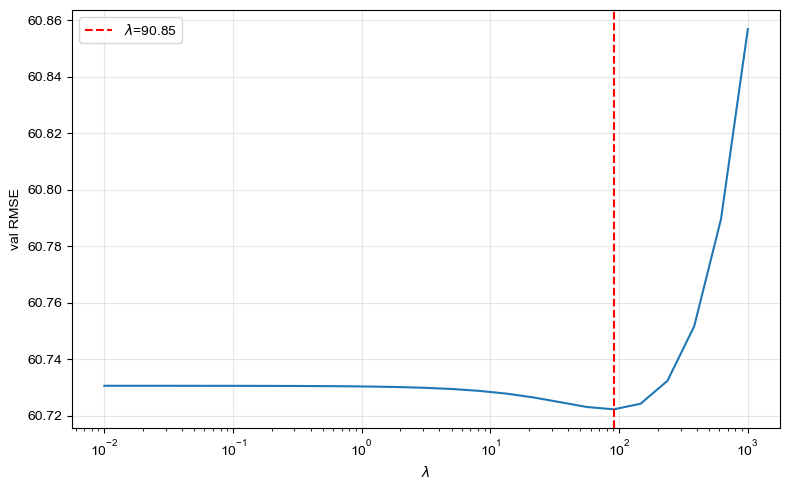

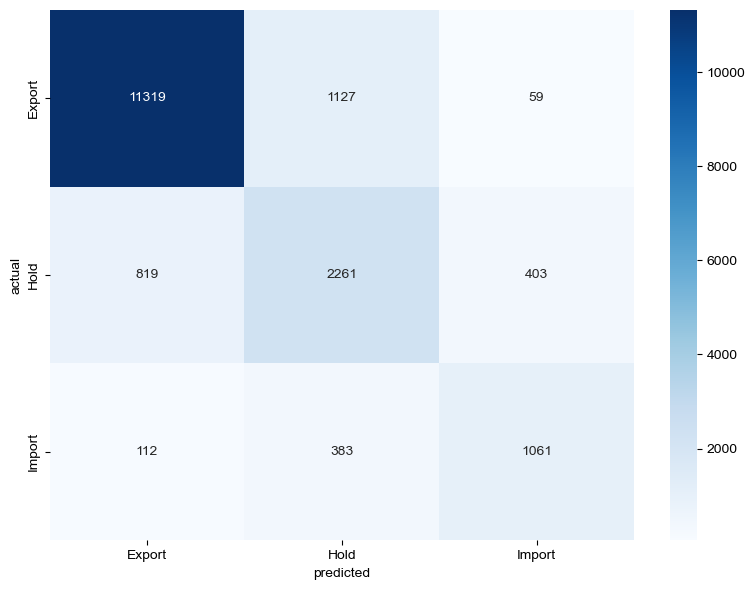

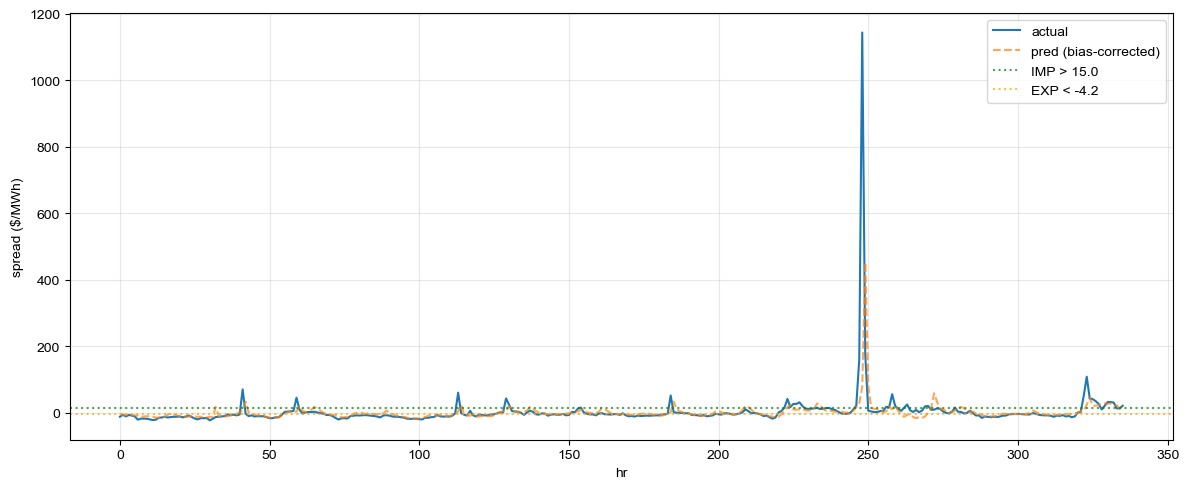

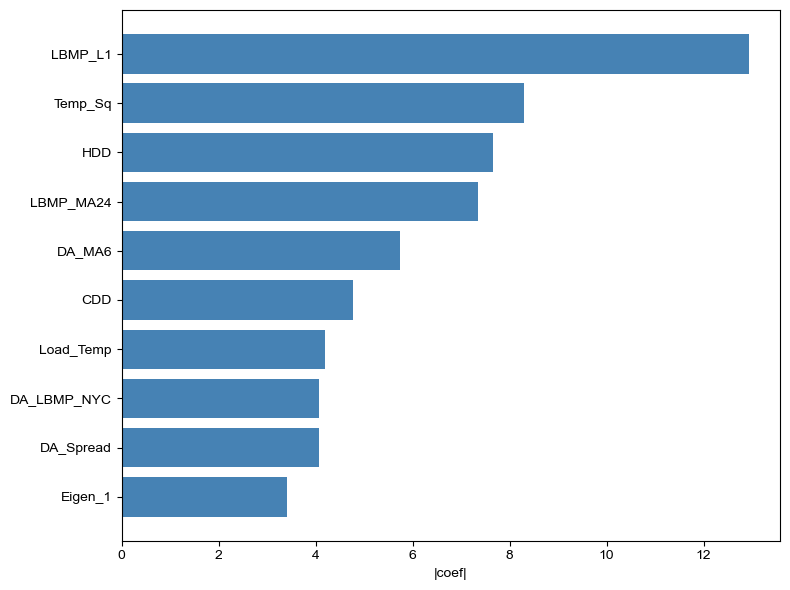

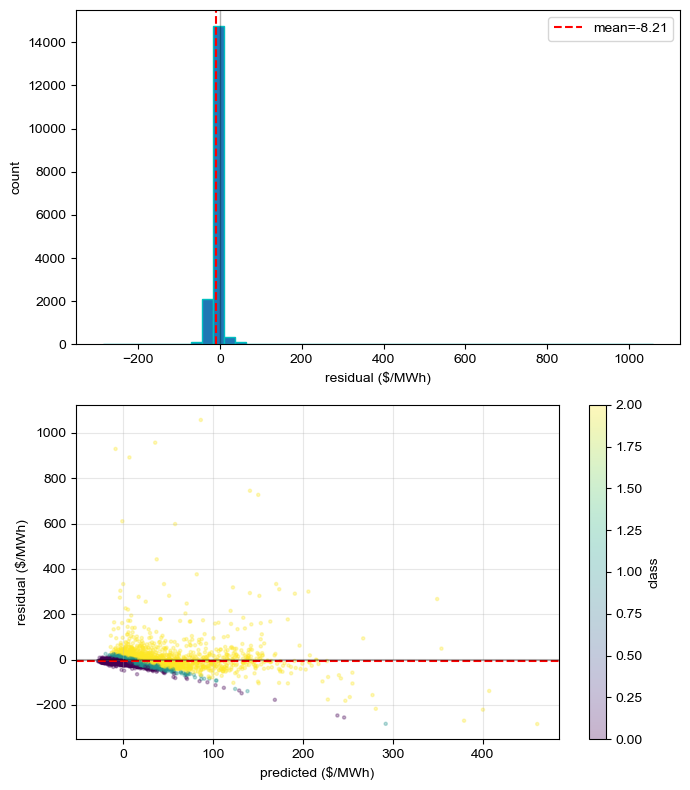

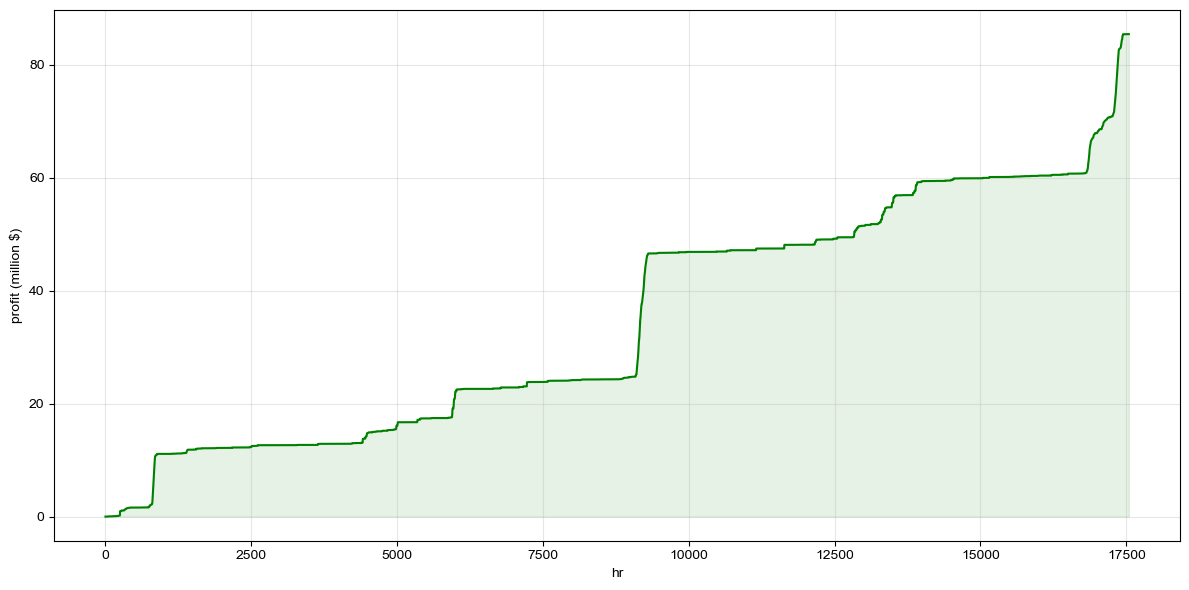

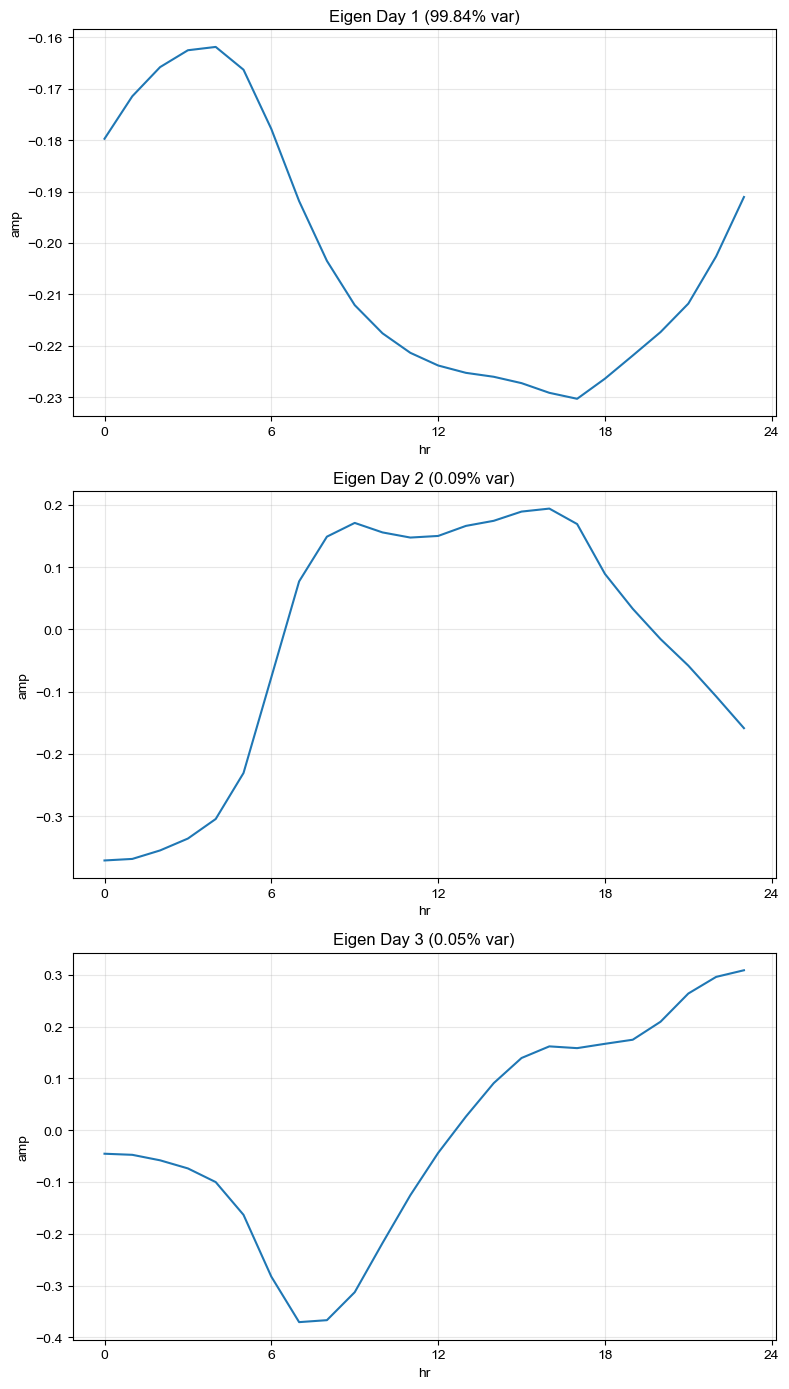

In [28]:
res = y_test - y_pred
res_mean, res_std = float(np.mean(res)), float(np.std(res))

plt.figure(figsize=(8, 5))
plt.semilogx(lams, val_rms)
plt.axvline(opt_lam, color='r', ls='--', label=f'$\\lambda$={opt_lam:.2f}')
plt.xlabel('$\\lambda$')
plt.ylabel('val RMSE')
plt.legend()
#plt.title('Hyperparam Tuning')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cls, yticklabels=cls)
#plt.title('Confusion Matrix')
plt.xlabel("predicted")
plt.ylabel("actual")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
idx = slice(0, min(336, len(y_test)))
plt.plot(y_test[idx], label='actual', lw=1.5)
plt.plot(y_corr[idx], '--', label='pred (bias-corrected)', alpha=0.7)
plt.axhline(th_high, color='g', ls=':', alpha=0.7, label=f'IMP > {th_high:.1f}')
plt.axhline(th_low, color='orange', ls=':', alpha=0.7, label=f'EXP < {th_low:.1f}')
plt.xlabel('hr')
plt.ylabel('spread ($/MWh)')
plt.legend()
#plt.title('Predictions (First 2 Weeks)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
top = np.argsort(np.abs(w))[-10:]
plt.barh([feat[i][:15] for i in top], np.abs(w)[top], color='steelblue')
plt.xlabel('|coef|')
#plt.title('Top Features by Importance')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(7, 8))
axes[0].hist(res, bins=50, edgecolor='c')
axes[0].axvline(res_mean, color='r', ls='--', label=f'mean={res_mean:.2f}')
axes[0].axvline(0, color='k', ls='-', lw=1, alpha=0.3)
axes[0].set_xlabel('residual ($/MWh)')
axes[0].set_ylabel('count')
#axes[0].set_title(f'Residual Distribution ($\\sigma$={res_std:.2f})')
axes[0].legend()
axes[1].set_xlabel('predicted ($/MWh)')
axes[1].set_ylabel('residual ($/MWh)')
#axes[1].set_title('Residual vs Predicted')
axes[1].grid(alpha=0.3)
sc = axes[1].scatter(y_pred, res, alpha=0.3, s=5, c=y_test_c, cmap='viridis')
axes[1].axhline(res_mean, color='r', ls='--')
axes[1].axhline(0, color='k', ls='-', alpha=0.3)
fig.colorbar(sc, ax=axes[1], label='class')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(len(profit)), profit / 1e6, 'g-')
plt.fill_between(range(len(profit)), 0, profit / 1e6, alpha=0.1, color='g')
plt.xlabel('hr')
plt.ylabel('profit (million $)')
#plt.title(f'Cumulative Profits (total ${profit[-1] / 1e6:.2f}M in 2 years)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 14))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(np.arange(24), d_eig[:, i])
    plt.xlabel('hr')
    plt.ylabel('amp')
    plt.title(f'Eigen Day {i + 1} ({(s[i]**2 / (s**2).sum()) * 100:.2f}% var)')
    plt.xticks([0, 6, 12, 18, 24])
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## References
[1] Mazumder, R., Hastie, T., & Tibshirani, R. (2010). Spectral regularization algorithms for learning large incomplete matrices. The Journal of Machine Learning Research, 11, 2287-2322.

[2] Bessembinder, H., & Lemmon, M. L. (2002). Equilibrium pricing and optimal hedging in electricity forward markets. the Journal of Finance, 57(3), 1347-1382.